In [1]:
import pandas as pd
import numpy
import string
import re
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense
from nltk.stem.porter import PorterStemmer
from pandas import DataFrame
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

Using TensorFlow backend.
/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/tensorflow/l

In [2]:
filename = r'Womens Clothing E-Commerce Reviews.csv'
WomensClothing= pd.read_csv(filename,encoding='latin-1')
WomensClothing.head(5)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [3]:
WomensClothing = WomensClothing.replace(0, numpy.NaN)
WomensClothing.dropna(inplace=True)
print(WomensClothing.shape)

(8572, 10)


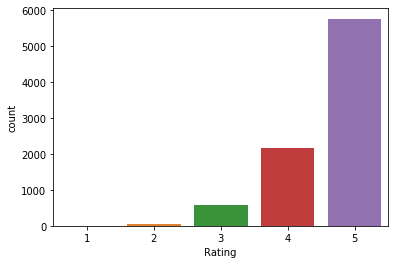

In [4]:
features = WomensClothing['Review Text'].astype(str)
labels = WomensClothing['Rating']
import seaborn as sns
WomensClothing.groupby('Rating')['Rating'].count()
sns.countplot(x='Rating', data=WomensClothing)

In [5]:
def clean_One_Twit(doc):
    tokens = doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    porter = PorterStemmer()
    stemmed = [porter.stem(word) for word in tokens]
    return stemmed

In [6]:
vocab = Counter()

for index, row in WomensClothing.iterrows():
    if index % 10000 ==0:
        print(index)
    text = row['Review Text']
    tokens = clean_One_Twit(text)
    vocab.update(tokens)
    
print(len(vocab))
print(vocab.most_common(50))

min_occurrence = 10
minvocab = [k for k,c in vocab.items() if c >= min_occurrence]
print(len(minvocab))

20000
8853
[('dress', 5041), ('fit', 4961), ('size', 4766), ('love', 4579), ('look', 3609), ('wear', 3447), ('top', 3409), ('like', 3091), ('color', 3012), ('great', 2423), ('im', 2413), ('order', 2037), ('would', 1986), ('fabric', 1970), ('small', 1904), ('perfect', 1731), ('thi', 1705), ('littl', 1695), ('nice', 1688), ('tri', 1624), ('flatter', 1623), ('realli', 1620), ('one', 1581), ('soft', 1470), ('beauti', 1404), ('usual', 1380), ('comfort', 1377), ('well', 1376), ('bit', 1314), ('bought', 1281), ('petit', 1260), ('length', 1207), ('jean', 1167), ('back', 1157), ('cute', 1157), ('run', 1154), ('waist', 1153), ('larg', 1130), ('think', 1091), ('work', 1090), ('also', 1042), ('skirt', 1038), ('store', 1035), ('much', 1035), ('sweater', 1034), ('long', 1028), ('materi', 1012), ('retail', 995), ('go', 992), ('make', 988)]
1774


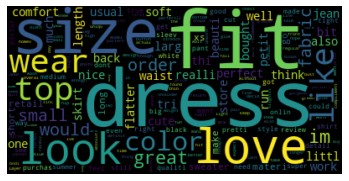

In [7]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate_from_frequencies(frequencies=vocab)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [8]:
def doc_to_line(oneTwit, vocab):
    tokens = clean_One_Twit(oneTwit)
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

lines = list()
for index, row in WomensClothing.iterrows():
    if index % 10000 ==0:
        print(index)
     
    text = row['Review Text']
    line = doc_to_line(text, minvocab)
    lines.append(line)
    
print(len(lines))

20000
8572


In [9]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

tokenizer = create_tokenizer(lines)
Xtrain = tokenizer.texts_to_matrix(lines, mode='freq')
print(Xtrain.shape)
n_words = Xtrain.shape[1]
print(n_words)

(8572, 1772)
1772


In [10]:
def evaluate_mode(Xtrain, ytrain, Xtest, ytest):
    scores = list()
    n_repeats = 1
    n_words = Xtest.shape[1]
    for i in range(n_repeats):
        # define network
        model = Sequential()
        model.add(Dense(50, input_shape=(n_words,), activation='relu'))
        model.add(Dense(6, activation='softmax'))
        # compile network
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        # fit network on the training dataset
        model.fit(Xtrain, ytrain, epochs=100, verbose=0)
        # evaluate the model on the unseen test dataset
        val_loss, val_acc = model.evaluate(Xtest, ytest, verbose=0)
        scores.append(val_acc)
        print('%d accuracy: %s' % ((i+1), val_acc))
    return scores

In [11]:
X_train, X_test, y_train, y_test = train_test_split(Xtrain, labels,
                                                    test_size=.20,
                                                    random_state=2020,
                                                    stratify=labels)

modes = ['binary', 'count', 'tfidf', 'freq']
results = DataFrame()
for mode in modes:
    # evaluate model on data for mode
    results[mode] = evaluate_mode(X_train, y_train, X_test, y_test)
    
# summarize results
print(results.describe())






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

1 accuracy: 0.6588921284015256
1 accuracy: 0.6728862974977354
1 accuracy: 0.6483965016662553
1 accuracy: 0.6612244899175606
         binary     count     tfidf      freq
count  1.000000  1.000000  1.000000  1.000000
mean   0.658892  0.672886  0.648397  0.661224
std         NaN       NaN       NaN       NaN
min    0.658892  0.672886  0.648397  0.661224
25%    0.658892  0.672886  0.648397  0.661224
50%    0.658892  0.672886  0.648397  0.661224
75%    0.658892  0.672886  0.648397  0.661224
max    0.658892  0.672886  0.648397  0.661224
